In [4]:
import warnings
from typing import final
from unicodedata import category

warnings.filterwarnings('ignore')

!pip install ucimlrepo numpy pandas scipy matplotlib

from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# **Zgodba – Opis problema:**
Naloga vključuje analizo nabora podatkov, ki vsebuje ocene kakovosti vina, kjer je cilj klasificirati vina v **visoko kakovostna** ali **nizko kakovostna**. Nabor podatkov vsebuje več atributov, povezanih s kemijskimi komponentami vin, kot so `fixed_acidity`, `volatile_acidity`, `citric_acid` itd. Cilj je napovedati kakovost vina na podlagi teh kemijskih lastnosti, pri čemer uporabimo **univariantno analizo**, **WoE (Teža dokaza)** transformacije, izračun **IV (Informacijska vrednost)**, in **coarse classing** za nadaljnje modeliranje v **Bayesovski mreži**.

Ocenjevanje kakovosti vina je dano kot celo število med 0 in 10, pri čemer so vina večinoma koncentrirana okoli ocen 5–7. Da bi izboljšali uspešnost modela, smo ustvarili binarno ciljno spremenljivko:  
- `target = 1`, če je `quality ≥ 7` (visoka kakovost)  
- `target = 0`, če je `quality < 7` (nizka kakovost)

# **1. Uvoz podatkov in pregled:**

Podatki uporabljeni v tem raziskovalnem delu so pridobljeni iz spletne strani () ter vsebujejo informacije o kvaliteti različnih vin. Skupno smo iz spletne strani pridobili dve podatkovni zbirki in sicer ločeni za rdeče vino (winequality-red.csv) in belo vino (winequality-white.csv). 

Podatke smo združili v eno tabelo ter dodali stolpec, ki določa za katero kategorijo vina gre. 

In [118]:
# Uvoz podatkov
red = pd.read_csv("winequality-red.csv", delimiter=";")
white = pd.read_csv("winequality-white.csv", delimiter=";")

# Dodamo stolpec z informacijo o barvi vina
red["color"] = 1
white["color"] = 0

# Združimo obe podatkovni zbirki
df = pd.concat([red, white], axis=0)
df[["color", "quality"]] = df[["color", "quality"]].astype("category")
print(f"PD ima {df.shape[0]} vrstic in {df.shape[1]} stolpcev")

df.head()

PD ima 6497 vrstic in 13 stolpcev


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


Po nalaganju podatkov pridobimo pregled nad njihovimi dimenzijami ( 6497 vrstic in 13 stolpcev) ter prvih nekaj vnosov za preverjanje pravilnosti nalaganja.

In [119]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


## 2. Analiza podatkov

### 2.1 Manjkajoče vrednosti

Preverjanje manjkajočih vrednosti pred analizo je izjemnega pomena zato pogledamo deleže manjkajočih vrednosti po posameznih stolpcih

In [120]:
num_of_missing_values_total = df.isna().sum().sum()
print(f"DF ima {((num_of_missing_values_total / (df.shape[0] * df.shape[1])) * 100)}% manjkajočih vrednsoti")
print()
missing_by_column = df.isna().sum()
missing_percent = (missing_by_column / len(df)) * 100
print(pd.DataFrame({'Manjkajoče vrednosti': missing_by_column, 'Odstotek (%)': missing_percent}))

DF ima 0.0% manjkajočih vrednsoti

                      Manjkajoče vrednosti  Odstotek (%)
fixed acidity                            0           0.0
volatile acidity                         0           0.0
citric acid                              0           0.0
residual sugar                           0           0.0
chlorides                                0           0.0
free sulfur dioxide                      0           0.0
total sulfur dioxide                     0           0.0
density                                  0           0.0
pH                                       0           0.0
sulphates                                0           0.0
alcohol                                  0           0.0
quality                                  0           0.0
color                                    0           0.0


V podatkovni zbirki **ni manjkajočih vrednosti**, zato dodatna obravnava ni potrebna.

V primeru prisotnosti manjkajočih vrednosti bi bile možne naslednje metode obravnave:
- zapolnitev s povprečno vrednostjo stolpca, mediano ali modusom,
- odstranitev vrstic ali stolpcev z veliko manjkajočimi podatki,
- uporaba naprednih metod, kot so KNN ali regresijski modeli.

### 2.2 Ekstremne vrednosti

Ekstremne vrednosti (Z-vrednosti > 3 ali < -3) so podatki, ki se močno oddaljijo od povprečja v pozitivno ali v negativno smer. Te vrednosti so običajno zelo redke in pogosto označujejo odstopanja od običajnega vedenja v podatkih.

Za zaznavanje ekstremnih vrednosti smo uporabili Z-vrednosti, kjer štejemo vrednosti z |Z| > 3 kot ekstremne.

In [121]:
# Izberemo samo numerične stolpce
numeric_df = df.select_dtypes(include=[np.number])

# Izračunamo Z-vrednosti
z_scores = (numeric_df - numeric_df.mean()) / numeric_df.std()

# Poiščemo ekstreme (Z-vrednosti večje od 3 ali manjše od -3)
extremes_per_col = (abs(z_scores) > 3).sum(axis=0)

# Kreiramo DataFrame za ekstreme
df_extremes = pd.DataFrame(extremes_per_col, columns=["Ekstremi"], index=numeric_df.columns)

# Izračunamo odstotek ekstremnih vrednosti
df_extremes["Ekstremi (%)"] = (df_extremes["Ekstremi"] / len(df)) * 100

# Sortiramo po številu ekstremnih vrednosti
df_extremes.sort_values(by="Ekstremi", ascending=False, inplace=True)

df_extremes

,Ekstremi,Ekstremi (%)
fixed acidity,128,1.970140
chlorides,107,1.646914
volatile acidity,95,1.462213
sulphates,75,1.154379
free sulfur dioxide,36,0.554102
pH,33,0.507927
citric acid,28,0.430968
residual sugar,26,0.400185
total sulfur dioxide,8,0.123134
density,3,0.046175


V podatkih opazimo prisotnost ekstremnih vrednosti v večini spremenljivk, kar pomeni, da so nekateri podatki zelo oddaljeni od povprečja. Kljub temu, da je odstotek ekstremnih vrednosti za večino spremenljivk relativno nizek (manj kot 2%), so nekateri stolpci, kot sta Fixed Acidity in Chlorides, precej bolj občutljivi na odstopanja.

Večje število ekstremnih vrednosti v spremenljivkah, kot so Fixed Acidity (1.97%) in Chlorides (1.65%), nakazuje, da so podatki v teh stolpcih bolj razpršeni, kar pomeni, da se nekatere vrednosti močno oddaljijo od povprečja. Vendar pa Residual Sugar (0.4%) in Total Sulfur Dioxide (0.12%) imata minimalno število ekstremov, kar pomeni, da so ta podatki bolj stabilni in ne izstopajo iz pričakovanih mej.

Čeprav večina ekstremnih vrednosti ne presega 2%, je pomembno, da jih obravnavamo, ker lahko vplivajo na rezultate analiz ali modelov, še posebej pri metodah, ki so občutljive na ekstremne vrednosti. 

Zaradi tega bi bilo smiselno upoštevati metode obravnave ekstremnih vrednosti, kot so normalizacija, transformacije, odstranitev.

### Z-distribucija posameznih spremenljivk

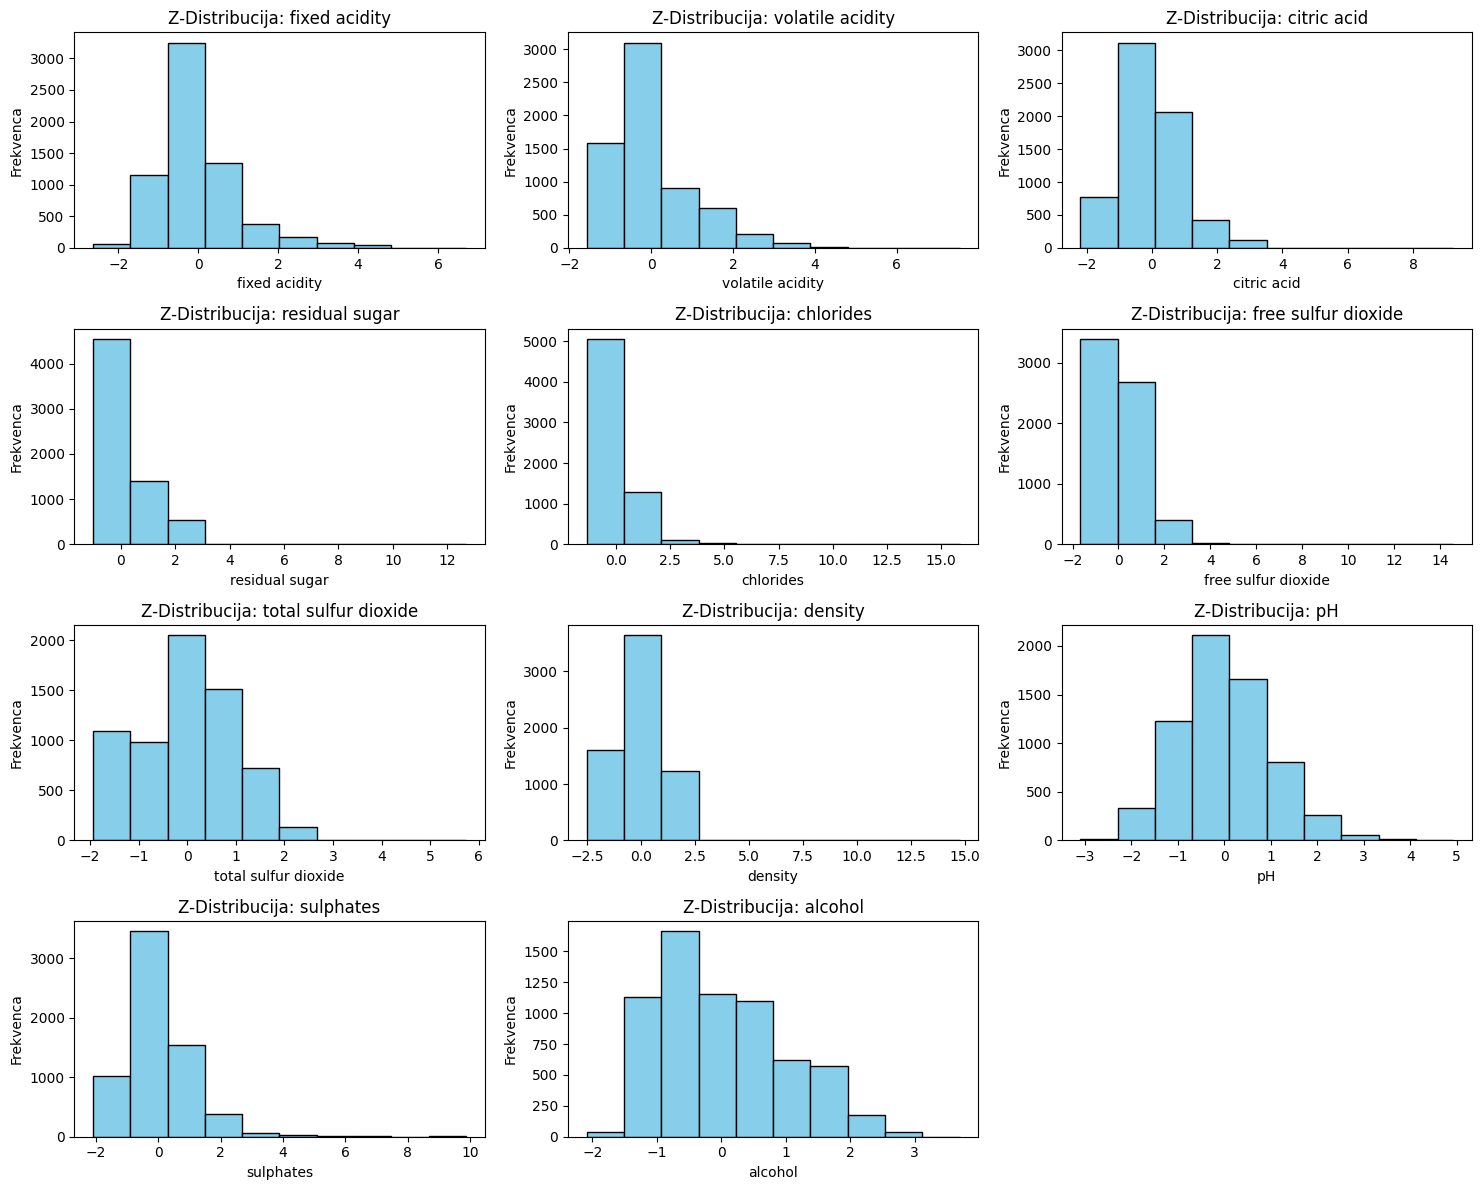

In [122]:
numeric_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    plt.hist(z_scores[col], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Z-Distribucija: {col}')
    plt.xlabel(col)
    plt.ylabel('Frekvenca')
plt.tight_layout()
plt.show()

- **Fixed Acidity**: Porazdelitev Z-vrednosti je **desno asimetrična** z večino vrednosti v območju med -2 in 2, kar pomeni, da je večina podatkov znotraj povprečja in le nekaj ekstremnih vrednosti na zunanji strani.

- **Volatile Acidity**: Porazdelitev Z-vrednosti je **močno desno asimetrična**, saj so nekatere vrednosti precej oddaljene od povprečja (zlasti z visokimi Z-vrednostmi), kar kaže na prisotnost ekstremnih vrednosti.

- **Citric Acid**: Z-distribucija je **desno asimetrična**, z večino vrednosti blizu 0, kar kaže na to, da večina vin vsebuje zelo malo citronske kisline.

- **Residual Sugar**: Z-distribucija je **močno desno asimetrična**, z dolgotrajnim repom, ki sega daleč od povprečja, kar pomeni prisotnost ekstremnih vrednosti.

- **Chlorides**: Porazdelitev Z-vrednosti je **desno asimetrična** s koncentracijo vrednosti blizu 0, vendar obstajajo tudi redke vrednosti z višjimi Z-vrednostmi.

- **Free Sulfur Dioxide**: Z-distribucija je **desno asimetrična**, z večino vrednosti med 0 in 4, vendar nekaj redkih vrednosti, ki izstopajo.

- **Total Sulfur Dioxide**: Porazdelitev Z-vrednosti je bolj **razpršena** z nekaj vrhov, kar kaže na raznolikost v vsebnosti žveplovega dioksida.

- **Density**: Porazdelitev Z-vrednosti je **relativno simetrična**, kar pomeni, da je gostota vina v večini primerov precej enotna.

- **pH**: Porazdelitev Z-vrednosti je **blizu normalne**, kar kaže na to, da so vrednosti pH v večini primerov znotraj normalnega območja.

- **Sulphates**: Z-distribucija je **desno asimetrična** in vsebuje dolgi rep, kar pomeni, da ima nekaj primerkov zelo visoke vrednosti sulfata.

- **Alcohol**: Porazdelitev Z-vrednosti je **blizu normalne**, vendar s šibkim desnim repom, kar pomeni, da so večina vrednosti v območju 9-13 %, z nekaj primerki z višjo vsebnostjo alkohola.

### 2.3 MinMax transformacija


MinMax transformacija je tehnika, ki se uporablja za normalizacijo podatkov ter transformacijo podatkov v določen obseg (ponavadi med 0 in 1). Ta metoda je zelo koristna ko so v podatkih prisotne ekstremne vrednosti (outliers), saj omogoča zmanjševanje vpliva teh vrednosti na analizo ali modele. 

Za vsak stolpec smo uporabili spodnjo formulo:

$$
X' = \frac{X - \min(X)}{\max(X) - \min(X)}
$$

Kjer:
- **X** predstavlja izvorno vrednost.
- **min(X)** je najmanjša vrednost v atributu.
- **max(X)** je največja vrednost v atributu.
- **X'** je normalizirana vrednost, ki bo v območju od **0 do 1**.


In [123]:
def minmax(df, target_col):
    df_tmp = df.copy()
    for col in df:
        if col == target_col:
            continue
        df_tmp[col] = (df[col] -df[col].min()) / (df[col].max() - df[col].min())
    return df_tmp

# Izberemo samo numericne
numeric_df = df.select_dtypes(include=[np.number])

scaled_df = minmax(numeric_df, "quality")
scaled_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899
1,0.330579,0.533333,0.000000,0.030675,0.147841,0.083333,0.140553,0.186813,0.372093,0.258427,0.260870
2,0.330579,0.453333,0.024096,0.026074,0.137874,0.048611,0.110599,0.190669,0.418605,0.241573,0.260870
3,0.611570,0.133333,0.337349,0.019939,0.109635,0.055556,0.124424,0.209948,0.341085,0.202247,0.260870
4,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899


Ekstremne vrednosti (outliers), ki so običajno izven običajnega območja podatkov (npr. zelo nizke ali zelo visoke vrednosti), bodo po Min/Max transformaciji približane obsegu od 0 do 1. To pomeni, da ne bodo imele tolikšnega vpliva na nadaljnje analize ali modeliranje. Po Min/Max transformaciji bodo te vrednosti pripeljane v enoten obseg, kar omogoča enostavnejše modeliranje in primerjavo teh atributov, ne glede na njihove različne obsege v originalnih podatkih.

Če vzamemo primer Fixed Acidity ali Chlorides, ki vsebujejo ekstremne vrednosti, bo Min/Max transformacija te vrednosti poravnala, zaradi česar ne bodo več izstopale iz običajnega razpona in izkrivljale analize.

Koncentracije, kot so alkohol, sulfati ali kislost vinu, se lahko zelo razlikujejo med različnimi vini. Nekatera vina so lahko zelo kisla ali zelo alkoholna, kar povzroči ekstremne vrednosti. Po Min/Max transformaciji bodo te vrednosti pripeljane v enoten obseg, kar omogoča enostavnejše modeliranje in primerjavo teh atributov, ne glede na njihove različne obsege v originalnih podatkih.

### 3.4 Distribucije

Poglejmo si distribucije MinMax transformiranih spremenljivk

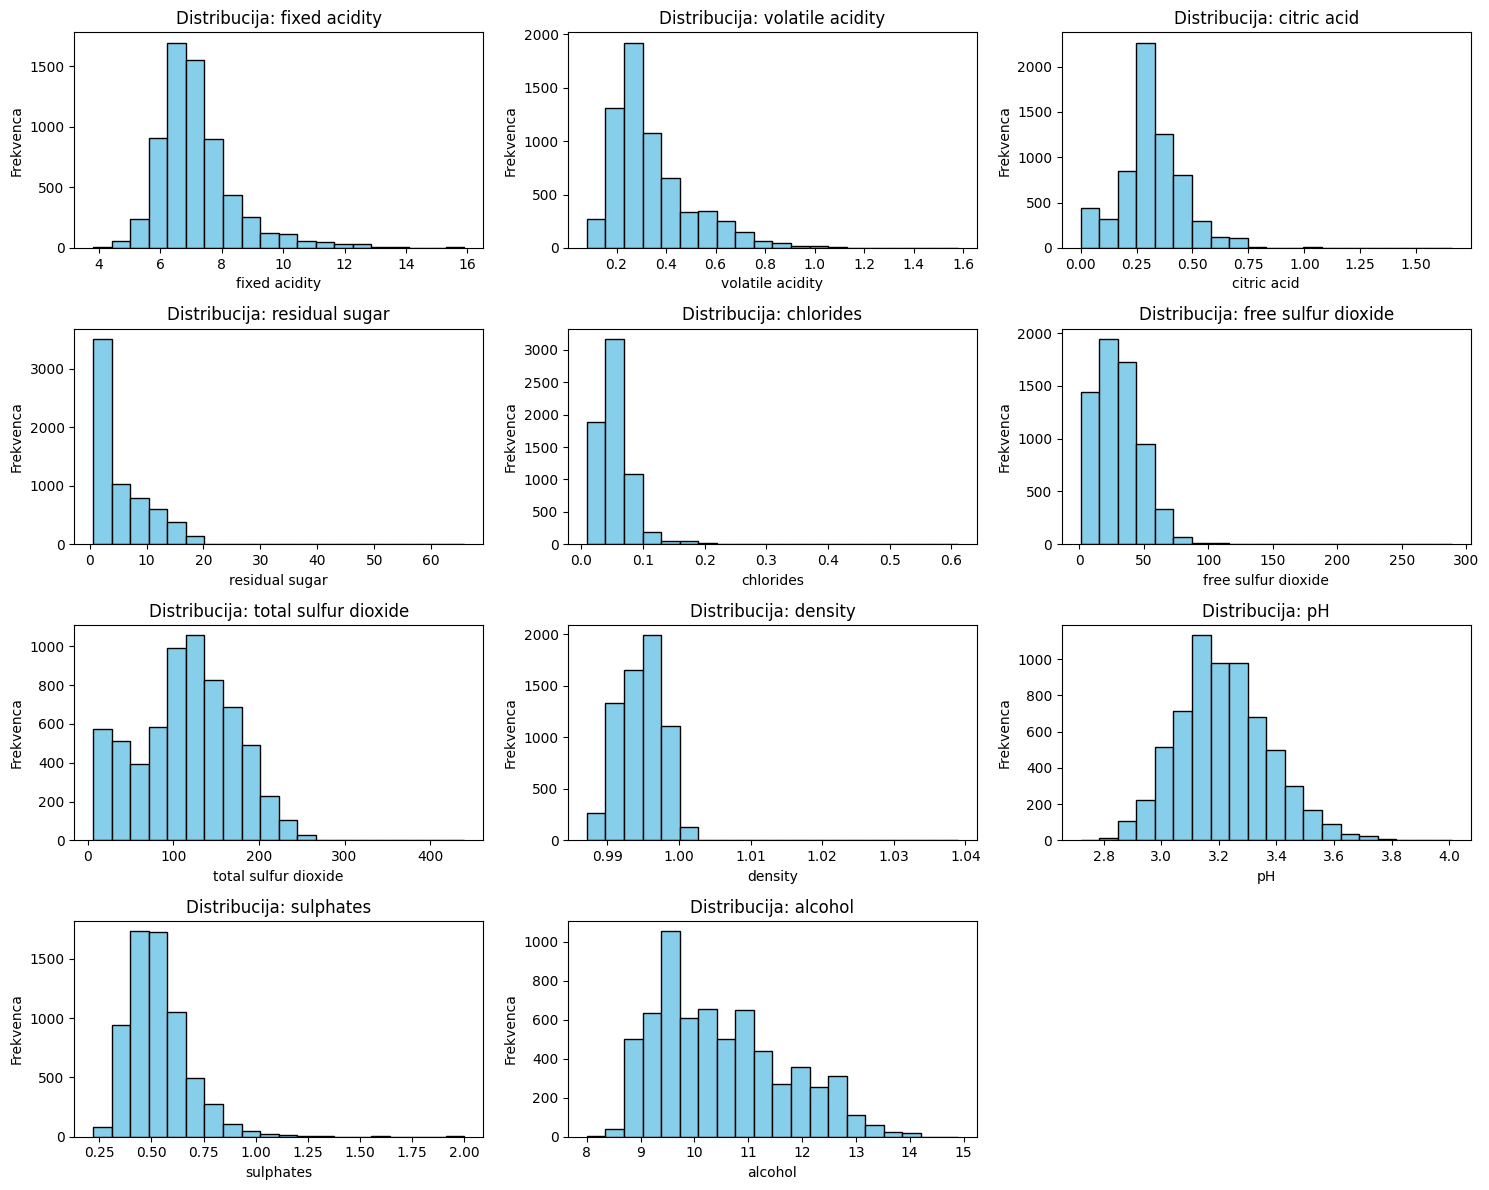

In [124]:
numeric_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribucija: {col}')
    plt.xlabel(col)
    plt.ylabel('Frekvenca')
plt.tight_layout()
plt.show()

### Ugotovitve na podlagi histogramov porazdelitev posameznih spremenljivk

Na osnovi analiziranih histogramov lahko ugotovimo naslednje značilnosti porazdelitev posameznih spremenljivk:

- **Fixed_acidity**: Porazdelitev je rahlo desno asimetrična, kjer se večina vrednosti nahaja med 6 in 8. Kljub temu je porazdelitev relativno stabilna brez izrazitih ekstremnih vrednosti.

- **Volatile_acidity**: Porazdelitev je močno desno asimetrična, z dolgim repom, kar pomeni, da je prisotnih nekaj redkih primerov z visokimi vrednostmi. 

- **Citric_acid**: Podobno kot **volatile_acidity** je tudi ta spremenljivka desno asimetrična, kjer je veliko vrednosti blizu 0, kar pomeni, da večina vin nima izrazite citronske kisline.

- **Residual_sugar**: Ta spremenljivka je izrazito desno asimetrična, z zelo dolgim repom, kar nakazuje prisotnost ekstremnih vrednosti. 

- **Chlorides**: Vrednosti so koncentrirane v nižjem območju, s dolgim repom na desni strani. 

- **Free_sulfur_dioxide**: Večina vrednosti je koncentrirana med 0 in 50, vendar je porazdelitev desno asimetrična, kar nakazuje, da so številne vrednosti nizke, medtem ko nekaj redkih primerov dosega višje vrednosti.

- **Total_sulfur_dioxide**: Porazdelitev je bolj razpršena, z nekaj vrhov, kar nakazuje raznovrstnost v vrednostih, vendar brez močne asimetrije.

- **Density**: Porazdelitev je zelo ozka in skoraj simetrična, kar pomeni, da večina vin ima podobno gostoto.

- **pH**: Porazdelitev je približno simetrična in se zelo približuje normalni porazdelitvi, brez večjih odstopanj od povprečja.

- **Sulphates**: Porazdelitev je desno asimetrična, s repom, ki sega do 2, kar je relativno redko.

- **Alcohol**: Porazdelitev je normalna z zelo šibkim desnim repom, kar pomeni, da večina vin vsebuje alkohol med 9 in 13 %, z nekaj primerki z višjo vsebnostjo.

Po **Min/Max skaliranju** je razporeditev podatkov postala bolj uravnotežena. To je še posebej pomembno za nadaljnje analize ali strojno učenje, kjer se manjša vpliv ekstremnih vrednosti, omogoča boljšo primerljivost atributov in pomaga modelom delovati bolje, ko so vsi atributi na istem obsegu.

## 3.5 Statistične mere

In [125]:
stat_data = []
numeric_cols = df.select_dtypes(include=[np.number])

for col in numeric_cols:
    mean = scaled_df[col].mean()
    median = scaled_df[col].median()
    std = scaled_df[col].std()
    var = scaled_df[col].var()
    alfa3 = skew(scaled_df[col])
    alfa4 = kurtosis(scaled_df[col])
    stat_data.append([col, mean, median, std, var, alfa3, alfa4])
 
stat_df = pd.DataFrame(stat_data, columns=["Atribut", "Mean", "Median", "Std", "Variance", "Alfa3 (Skew)", "Alfa4 (Kurtosis)"])
stat_df


,Atribut,Mean,Median,Std,Variance,Alfa3 (Skew),Alfa4 (Kurtosis)
0,fixed acidity,0.282257,0.264463,0.107143,0.011480,1.722892,5.056343
1,volatile acidity,0.173111,0.140000,0.109758,0.012047,1.494751,2.822275
2,citric acid,0.191948,0.186747,0.087541,0.007663,0.471622,2.394471
3,residual sugar,0.074283,0.036810,0.072972,0.005325,1.435073,4.354994
4,chlorides,0.078129,0.063123,0.058195,0.003387,5.398581,50.857966
5,free sulfur dioxide,0.102518,0.097222,0.061630,0.003798,1.219784,7.899231
6,total sulfur dioxide,0.252868,0.258065,0.130235,0.016961,-0.001177,-0.372301
7,density,0.146262,0.149990,0.057811,0.003342,0.503485,6.600061
8,pH,0.386435,0.379845,0.124641,0.015535,0.386749,0.366451
9,sulphates,0.174870,0.162921,0.083599,0.006989,1.796855,8.646117


Zaradi visoke vrednosti **kurtosis** (50) pri spremenljivki **chlorides**, ki nakazuje prisotnost ekstremnih vrednosti (outliers), bomo pred izvedbo Min/Max skaliranja **chlorides** klipali na 1. in 99. percentil.

To pomeni, da bomo vse vrednosti, ki so manjše od 1. percentila, zamenjali z 1. percentilom, in vse vrednosti, ki so večje od 99. percentila, zamenjali z 99. percentilom, da zmanjšamo vpliv ekstremnih vrednosti.


In [126]:
# Izračun 1. percentil (spodnjo mejo) za spremenljivko 'chlorides'
lower_bound = df['chlorides'].quantile(0.01)
# Izračun 99. percentil (zgornjo mejo) za spremenljivko 'chlorides'
upper_bound = df['chlorides'].quantile(0.99)

# Klipanje vrednosti v stolpcu 'chlorides' na zgoraj definirane meje
chlorides = df['chlorides'].clip(lower=lower_bound, upper=upper_bound)

# Izvedemo MinMax
min_val = chlorides.min()
max_val = chlorides.max()
minmax_chlorides = (chlorides - min_val) / (max_val - min_val)

# Zamenjamo serijo 
scaled_df['chlorides'] = minmax_chlorides


Ponovno preverimo statistične mere

In [127]:
stat_data = []
numeric_cols = scaled_df.select_dtypes(include=[np.number])

for col in numeric_cols:
    mean = scaled_df[col].mean()
    median = scaled_df[col].median()
    std = scaled_df[col].std()
    var = scaled_df[col].var()
    alfa3 = skew(scaled_df[col])
    alfa4 = kurtosis(scaled_df[col])
    stat_data.append([col, mean, median, std, var, alfa3, alfa4])
 
stat_df = pd.DataFrame(stat_data, columns=["Atribut", "Mean", "Median", "Std", "Variance", "Alfa3 (Skew)", "Alfa4 (Kurtosis)"])
stat_df

,Atribut,Mean,Median,Std,Variance,Alfa3 (Skew),Alfa4 (Kurtosis)
0,fixed acidity,0.282257,0.264463,0.107143,0.011480,1.722892,5.056343
1,volatile acidity,0.173111,0.140000,0.109758,0.012047,1.494751,2.822275
2,citric acid,0.191948,0.186747,0.087541,0.007663,0.471622,2.394471
3,residual sugar,0.074283,0.036810,0.072972,0.005325,1.435073,4.354994
4,chlorides,0.205998,0.157423,0.165077,0.027250,2.220455,6.748040
5,free sulfur dioxide,0.102518,0.097222,0.061630,0.003798,1.219784,7.899231
6,total sulfur dioxide,0.252868,0.258065,0.130235,0.016961,-0.001177,-0.372301
7,density,0.146262,0.149990,0.057811,0.003342,0.503485,6.600061
8,pH,0.386435,0.379845,0.124641,0.015535,0.386749,0.366451
9,sulphates,0.174870,0.162921,0.083599,0.006989,1.796855,8.646117


### Na podlagi izračunanih statističnih meritev za numerične atributa lahko ugotovimo naslednje:

Večina spremenljivk ima **srednjo vrednost** in **mediano** dokaj blizu, kar nakazuje **razmeroma uravnoteženo porazdelitev**. **Standardni odklon** in **varianca** se med spremenljivkami močno razlikujeta, kar kaže na **različno razpršenost podatkov**. Nekateri atributi imajo večjo razpršenost (npr. **chlorides**, **sulphates**), medtem ko so drugi bolj koncentrirani okoli povprečja (npr. **density**).

**Asimetrija (alfa3)** pri večini atributov kaže na **pozitivno asimetrijo**, kar pomeni, da je večina vrednosti skoncentriranih pri **nižjih vrednostih** z **redkimi višjimi izjemami**. Nekateri atributi imajo tudi **negativno asimetrijo**, kar nakazuje obratno porazdelitev, kjer so večje vrednosti bolj pogoste kot nižje.

**Sploščenost (alfa4)** je pri nekaterih atributih večja od 3, kar pomeni, da imajo več **ekstremnih vrednosti** kot **normalna porazdelitev**. Atributi s približno normalno porazdelitvijo imajo **alfa4** blizu 0, kar kaže, da porazdelitev nima izrazitih ekstremov in se bolj podobna normalni porazdelitvi.

Te statistične mere skupaj omogočajo boljše razumevanje oblike, širine in značaja **porazdelitve** vrednosti za vsak atribut, kar je koristno pri odločanju o nadaljnjih korakih za obdelavo podatkov (npr. transformacije, obravnava ekstremnih vrednosti).

### 3.6 Ustvarjanje ciljne spremenljivke

V podatkovni zbirki je že prisoten atribut `quality`, ki predstavlja kakovost vina na lestvici od 0 do 10. Ker je atribut diskreten, a ima porazdelitev skoncentrirano predvsem med vrednostmi 5, 6 in 7, smo za potrebe klasifikacije ustvarili **binarno ciljno spremenljivko**:

- `target = 1`, če je `quality ≥ 6` → visoka kakovost
- `target = 0`, če je `quality < 6` → povprečna ali nizka kakovost

Ta razdelitev omogoča jasnejšo ločnico med kakovostnimi in manj kakovostnimi vini ter je bolj primerna za nadaljnjo analizo in modeliranje (pri Bayesian mreži).

In [140]:
df_final = scaled_df.copy()
df_final[["color", "quality"]] = df[["color", "quality"]].astype("int")
df_final['quality'] = (df_final['quality'] >= 6).astype(int)
df_final

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,0.297521,0.413333,0.000000,0.019939,0.333010,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,1,0
1,0.330579,0.533333,0.000000,0.030675,0.466215,0.083333,0.140553,0.186813,0.372093,0.258427,0.260870,1,0
2,0.330579,0.453333,0.024096,0.026074,0.429886,0.048611,0.110599,0.190669,0.418605,0.241573,0.260870,1,0
3,0.611570,0.133333,0.337349,0.019939,0.326956,0.055556,0.124424,0.209948,0.341085,0.202247,0.260870,1,1
4,0.297521,0.413333,0.000000,0.019939,0.333010,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,0.198347,0.086667,0.174699,0.015337,0.108985,0.079861,0.198157,0.077694,0.426357,0.157303,0.463768,0,1
4894,0.231405,0.160000,0.216867,0.113497,0.157423,0.194444,0.373272,0.150183,0.333333,0.134831,0.231884,0,0
4895,0.223140,0.106667,0.114458,0.009202,0.121095,0.100694,0.241935,0.104685,0.209302,0.134831,0.202899,0,1
4896,0.140496,0.140000,0.180723,0.007669,0.006055,0.065972,0.239631,0.030461,0.480620,0.089888,0.695652,0,1


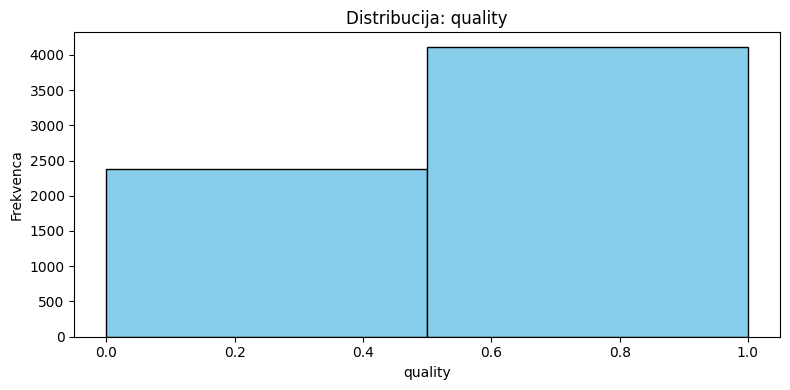

In [141]:
plt.figure(figsize=(8, 4))
plt.hist(df_final["quality"], bins=2, color='skyblue', edgecolor='black')
plt.title(f'Distribucija: quality')
plt.xlabel("quality")
plt.ylabel('Frekvenca')
plt.tight_layout()
plt.show()

### Komentarji in zaključki za vse zgoraj obravnavane teme

Na podlagi izvedenih analiz in obdelave podatkov smo pridobili pomembne vpoglede in sprejeli ključne odločitve, ki bodo vplivale na nadaljnje korake pri modeliranju:

1. **Porazdelitev podatkov**:
   - Večina atributov kaže na **desno asimetričnost**, kar pomeni, da so vrednosti skoncentrirane pri nižjih vrednostih, z redkimi višjimi ekstremi. To je pomembno, saj lahko ekstremne vrednosti vplivajo na analizo, zlasti pri modelih, ki niso odporni na outlierje.
   - Za obvladovanje ekstremnih vrednosti smo uporabili **Min/Max transformacijo**, ki je normalizirala podatke v obseg [0, 1]. Vendar pa Min/Max transformacija **ni zmanjšala vpliva ekstremnih vrednosti**, zato smo se odločili za dodatne tehnike obvladovanja ekstremov, kot je **clipping** na 1. in 99. percentil, da zmanjšamo vpliv teh vrednosti.

2. **Statistične meritve**:
   - Z uporabo **povprečja**, **median**, **standardnega odklona** in **kurtosis** smo opazili, da večina atributov kaže **pozitivno asimetrijo**, kar pomeni, da večina vrednosti leži pri spodnjem delu razpona z nekaj redkimi visokimi vrednostmi. To nakazuje, da so atributi, kot so **chlorides** in **sulphates**, bolj izpostavljeni ekstremnim vrednostim.
   - **Kurtosis** je bil za nekatere atribute zelo visok, zlasti za **chlorides**, kar nakazuje na prisotnost **ekstremnih vrednosti** (outliers), ki bi lahko izkrivile nadaljnje analize in modele. Zaradi tega smo se odločili za **Clipping** te spremenljivke pred transformacijo, da omilimo vpliv ekstremnih vrednosti.

3. **Ustvarjanje ciljne spremenljivke**:
   - Ker je atribut **quality** diskreten, smo za potrebe klasifikacije ustvarili **binarno ciljno spremenljivko**:
     - `target = 1`, če je `quality ≥ 6` (visoka kakovost).
     - `target = 0`, če je `quality < 6` (povprečna ali nizka kakovost).
   - Ta razdelitev omogoča jasnejšo ločnico med kakovostnimi in manj kakovostnimi vini ter je bolj primerna za nadaljnjo analizo in modeliranje, zlasti pri **Bayesian mreži**, kjer bomo lažje izvedli klasifikacijo.

### Zaključek:
- Uporabljene tehnike, kot so **Min/Max transformacija**, **clipping** so pripomogle k boljši obravnavi ekstremnih vrednosti in pripravi podatkov za nadaljnjo analizo.
- S pomočjo **binarne ciljne spremenljivke** smo poenostavili nalogo razvrščanja in izboljšali učinkovitost modelov za **klasifikacijo**.
- Zdaj imamo pripravljene podatke, ki so primerni za nadaljnjo analizo in modeliranje, predvsem pri uporabi **Bayesian mrež** in drugih metod za klasifikacijo, ki zahtevajo normalizirane in pripravljene podatke.

# 4 Univariantna analiza

### 4.1 Izračun WoE in IV

Za boljše razumevanje napovedne moči posameznih spremenljivk in za prepoznavanje, katere spremenljivke so najbolj informativne za naš model, bomo izvedli univariantno analizo. To vključuje izračun dveh pomembnih meritev:

1.	Weight of Evidence (WoE): Meritev, ki primerja porazdelitev pozitivnih (dogodek) in negativnih (brez dogodka) izidov v različnih razredih (bin) spremenljivke. Uporablja se predvsem pri kategorialnih ali diskretiziranih spremenljivkah v napovedovanju (npr. kreditni scoring, binarna klasifikacija).

2. Information Value (IV): Meritev, ki kvantificira napovedno moč spremenljivke z ocenjevanjem, kako dobro ločuje ciljne razrede. Višja kot je vrednost IV, bolj napovedna je spremenljivka.


In [148]:
print(df_final.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color', 'quality'],
      dtype='object')


In [146]:
# Funkcija za izračun WoE in IV
def calc_woe_iv(df, feature, target):
    eps = 0.0001  # zaradi deljenja z 0
    df = df[[feature, target]].copy()
    
    # Poskrbimo, da bosta 'feature' in 'target' numerična
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
    df[target] = pd.to_numeric(df[target], errors='coerce')
    
    # Deljenje spremenljivke na 10 bin-ov, če je potrebno
    if df[feature].nunique() > 2:
        df['bin'] = pd.qcut(df[feature], q=10, duplicates='drop')  # Za več kot 2 vrednosti (kategorije)
    else:
        df['bin'] = df[feature]  # Za binarno spremenljivko (0 in 1)

    grouped = df.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'event']
    grouped['non_event'] = grouped['total'] - grouped['event']
 
    event_total = grouped['event'].sum()
    non_event_total = grouped['non_event'].sum()

    grouped['event_dist'] = grouped['event'] / event_total
    grouped['non_event_dist'] = grouped['non_event'] / non_event_total
 
    # Izračun WoE
    grouped['woe'] = np.log((grouped['event_dist'] + eps) / (grouped['non_event_dist'] + eps))
    
    # Izračun IV
    grouped['iv'] = (grouped['event_dist'] - grouped['non_event_dist']) * grouped['woe']

    iv = grouped['iv'].sum()
    grouped = grouped.reset_index()
    return grouped[['bin', 'woe']], iv

In [149]:
# Izračun WoE in IV za vse spremenljivke
woe_df = df_final.copy()  # kopija podatkov
iv_values = {}  # prazni slovar za shranjevanje IV vrednosti

# Za vsako numerično spremenljivko izračunamo WoE in IV
for col in df_final.select_dtypes(include=[float, int]).columns:
    if col == 'quality':  # Izključimo ciljno spremenljivko 'quality'
        continue

    woe_values, iv = calc_woe_iv(df_final, col, 'quality')  # izračun WoE in IV
    iv_values[col] = iv  # shranimo IV vrednost za spremenljivko

    # Ustvarimo mapo za WoE vrednosti za vsak bin
    bin_map = woe_values.set_index('bin')['woe'].to_dict()
    # Dodelimo WoE vrednosti za vsak primer v podatkih
    woe_df[f'{col}_woe'] = pd.qcut(df_final[col], q=10, duplicates='drop').map(bin_map)

# Izračunamo IV za vse spremenljivke in jih sortiramo po vrednosti IV
iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)

# Prikaz rezultatov
print(woe_df.head())  # Prikaz WoE vrednosti za prvih nekaj primerov
print(iv_df)  # Prikaz IV vrednosti za vse spremenljivke

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.297521          0.413333     0.000000        0.019939   0.333010   
1       0.330579          0.533333     0.000000        0.030675   0.466215   
2       0.330579          0.453333     0.024096        0.026074   0.429886   
3       0.611570          0.133333     0.337349        0.019939   0.326956   
4       0.297521          0.413333     0.000000        0.019939   0.333010   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034722              0.064516  0.206092  0.612403   0.191011   
1             0.083333              0.140553  0.186813  0.372093   0.258427   
2             0.048611              0.110599  0.190669  0.418605   0.241573   
3             0.055556              0.124424  0.209948  0.341085   0.202247   
4             0.034722              0.064516  0.206092  0.612403   0.191011   

   ...  citric acid_woe  residual sugar_woe  chlorides_w

Komentar rezultatov

Iz rezultatov analize WoE (Weight of Evidence) in IV (Information Value) za posamezne spremenljivke lahko sklepamo, da imajo nekatere spremenljivke zelo močan vpliv na kakovost vina, medtem ko so druge manj napovedne. Alkohol in gostota sta najbolj napovedni spremenljivki, saj imata izjemno visoke IV vrednosti (0.917 in 0.497). To pomeni, da močno ločita med kakovostjo vina in sta ključna dejavnika, ki vplivata na napoved kakovosti.

Naslednje spremenljivke, kot so volatilna kislost in chlorides, prav tako predstavljajo pomembne napovedne dejavnike, saj imata IV vrednosti 0.346 in 0.322. To pomeni, da imata močan vpliv na kvaliteto vina, vendar nekoliko manjši kot alkohol in gostota.

Kislost (citric acid), sulfati in total sulfur dioxide so prav tako pomembni, vendar z manjšo IV vrednostjo (med 0.07 in 0.26). Te spremenljivke bodo verjetno imela manjši vpliv na napoved kakovosti, vendar še vedno lahko prispevajo k izboljšanju modela.

Povprečna kislost (pH) in preostali sladkor imata najnižjo IV vrednost, kar pomeni, da imata najmanjši vpliv na kakovost vina. Te spremenljivke bodo morda manj koristne za napovedovanje kakovosti vina.

Binarna spremenljivka color barva vina (0.057), prav tako ni najbolj napovedna, vendar bi se lahko uporabila, če bi želeli poenostaviti model.


### 4.2 Izbor spremenljivk

Na podlagi IV vrednosti in WoE bomo za model izbrali naslednje spremenljivke:
- **Alkohol**: Najmočnejši napovednik, zato bo nujen za model.
- **Gostota**: Močno napovedna, z visoko IV vrednostjo, zato jo bomo vključili.
- **Volatilna kislost**: Ima pomembno IV vrednost, kar pomeni, da ima močan vpliv na kakovost vina.
- **Chlorides**: Prav tako pomembna za napoved kakovosti vina.
- **Citric acid**: Kljub temu, da je IV nekoliko nižja, še vedno lahko prispeva k modelu.

Spremenljivke z nizko IV vrednostjo, kot so pH, sulfati in preostali sladkor, bomo izključili iz modela, saj ne prispevajo bistveno k napovedi kakovosti vina. Prav tako bomo izključili color, ker ima zelo nizko IV vrednost in manj napovedno moč.

In [154]:
df_selected = df_final[['alcohol', 'density', 'volatile acidity', 'chlorides', 'citric acid']]  # Izbrane spremenljivke
df_selected["quality"] = df_final["quality"]
df_selected

,alcohol,density,volatile acidity,chlorides,citric acid,quality
0,0.202899,0.206092,0.413333,0.333010,0.000000,0
1,0.260870,0.186813,0.533333,0.466215,0.000000,0
2,0.260870,0.190669,0.453333,0.429886,0.024096,0
3,0.260870,0.209948,0.133333,0.326956,0.337349,1
4,0.202899,0.206092,0.413333,0.333010,0.000000,0
...,...,...,...,...,...,...
4893,0.463768,0.077694,0.086667,0.108985,0.174699,1
4894,0.231884,0.150183,0.160000,0.157423,0.216867,0
4895,0.202899,0.104685,0.106667,0.121095,0.114458,1
4896,0.695652,0.030461,0.140000,0.006055,0.180723,1


### 4.3 Coarse Classing – Grouping by WoE

Coarse classing je postopek, kjer spremenljivke razdelimo na različne kategorije ali skupine na podlagi WoE (Weight of Evidence) vrednosti. WoE vrednosti predstavljajo razmerje med verjetnostjo, da se bo dogodilo ali pa ne bo zgodilo določeno dejanje (npr. visoka kakovost vina), kar pomaga bolje razumeti, kako posamezne vrednosti spremenljivke vplivajo na ciljno spremenljivko.

S tem postopkom zmanjšamo število kategorij spremenljivk, saj jih združimo v širše razrede ali bin-e. To olajša interpretacijo, saj omogoča, da so podatki v bolj obvladljivih in smiselnih skupinah. Prav tako zmanjša kompleksnost modela, saj se model bolj osredotoči na glavne trende v podatkih, ne pa na drobne variacije, ki niso pomembne za napovedovanje cilja.

Coarse classing pripomore k bolj preprostem modeliranju in boljši generalizaciji modela, saj zmanjšuje možnost prekomernega prileganja (overfitting), ki se lahko zgodi, če model obravnava preveč podrobnosti v podatkih.


In [156]:
# Funkcija za coarse classing (razdelitev na kategorije) na podlagi WoE
def coarse_classing(df, feature, target, num_bins=5):
    # Izračun WoE in IV vrednosti za dano spremenljivko
    woe_values, iv = calc_woe_iv(df, feature, target)
    
    # Ustvarimo mapo WoE vrednosti za ustrezne bin-e
    # 'bin_map' povezuje vsako kategorijo (bin) z ustrezno WoE vrednostjo
    bin_map = woe_values.set_index('bin')['woe'].to_dict()

    # Ustvarimo nov stolpec, ki vsebuje WoE vrednosti, dodeljene za vsako kategorijo
    # 'pd.cut()' uporablja intervale (bins), da razdeli spremenljivko in dodeli WoE vrednosti
    df[f'{feature}_woe_classed'] = pd.cut(df[feature], bins=len(woe_values), labels=woe_values['woe'], include_lowest=True)

    return df, iv  # Vrne podatke z novim stolpcem in IV vrednostjo

# Uporabi coarse classing za izbrane spremenljivke
df_classed = df_selected.copy()  # Kopiraj podatke, da ohraniš izvirno DataFrame

# Izberi numerične stolpce za coarse classing, pri čemer izključi ciljno spremenljivko 'quality'
selected_cols = df_classed.select_dtypes(include=[float, int]).columns.tolist()
selected_cols.remove('quality')  # Izključimo ciljno spremenljivko

# Izvedemo coarse classing za vsak izbrani atribut
for col in selected_cols:
    df_classed, iv = coarse_classing(df_classed, col, 'quality')

df_classed

,alcohol,density,volatile acidity,chlorides,citric acid,quality,alcohol_woe_classed,density_woe_classed,volatile acidity_woe_classed,chlorides_woe_classed,citric acid_woe_classed
0,0.202899,0.206092,0.413333,0.333010,0.000000,0,-0.896679,0.439959,-0.041293,0.138906,-0.827990
1,0.260870,0.186813,0.533333,0.466215,0.000000,0,-0.896679,1.172932,-0.131607,-0.095898,-0.827990
2,0.260870,0.190669,0.453333,0.429886,0.024096,0,-0.896679,1.172932,-0.041293,-0.095898,-0.827990
3,0.260870,0.209948,0.133333,0.326956,0.337349,1,-0.896679,0.439959,0.738036,0.138906,0.725703
4,0.202899,0.206092,0.413333,0.333010,0.000000,0,-0.896679,0.439959,-0.041293,0.138906,-0.827990
...,...,...,...,...,...,...,...,...,...,...,...
4893,0.463768,0.077694,0.086667,0.108985,0.174699,1,-0.227956,1.833899,1.016883,0.869437,-0.653455
4894,0.231884,0.150183,0.160000,0.157423,0.216867,0,-0.896679,1.172932,0.738036,0.869437,-0.153797
4895,0.202899,0.104685,0.106667,0.121095,0.114458,1,-0.896679,1.172932,0.738036,0.869437,-0.653455
4896,0.695652,0.030461,0.140000,0.006055,0.180723,1,0.569025,1.833899,0.738036,1.163944,-0.653455


#### Izberemo samo WoE stolpce (ki vsebujejo '_woe' v imenu) in dodamo ciljno spremenljivko 'quality'

In [157]:
woe_columns = [col for col in df_classed.columns if '_woe' in col]  # Izberi vse stolpce z '_woe'
woe_columns.append('quality')  # Dodajamo še ciljno spremenljivko 'quality'

# Ustvarimo nov DataFrame z WoE stolpci in ciljno spremenljivko 'quality'
df_woe = df_classed[woe_columns]

# Shrani novi DataFrame v CSV datoteko
df_woe.to_csv('df_woe.csv', index=False)

# Prikaz prvega dela DataFrame-a za preverjanje
df_woe

,alcohol_woe_classed,density_woe_classed,volatile acidity_woe_classed,chlorides_woe_classed,citric acid_woe_classed,quality
0,-0.896679,0.439959,-0.041293,0.138906,-0.827990,0
1,-0.896679,1.172932,-0.131607,-0.095898,-0.827990,0
2,-0.896679,1.172932,-0.041293,-0.095898,-0.827990,0
3,-0.896679,0.439959,0.738036,0.138906,0.725703,1
4,-0.896679,0.439959,-0.041293,0.138906,-0.827990,0
...,...,...,...,...,...,...
4893,-0.227956,1.833899,1.016883,0.869437,-0.653455,1
4894,-0.896679,1.172932,0.738036,0.869437,-0.153797,0
4895,-0.896679,1.172932,0.738036,0.869437,-0.653455,1
4896,0.569025,1.833899,0.738036,1.163944,-0.653455,1


In [158]:
df_woe.to_csv('woe_coarse_df.csv', index=False)

### 4.4 Zgodba in opis problema

V tem projektu se osredotočamo na napovedovanje kakovosti vina na podlagi različnih kemijskih lastnosti, kot so kislost, alkohol, sulfati in sladkor. Podatki so zajeti iz dveh različnih vrst vin – rdečega in belega vina – in vključujejo različne atribute, ki so lahko pomembni za napoved kakovosti vina.

Ciljna spremenljivka v tem primeru je kakovost vina, ki je razdeljena na lestvico od 0 do 10. Vendar pa so vrednosti pogosto skoncentrirane predvsem okoli vrednosti 5, 6 in 7, kar pomeni, da imamo opravka z diskretno porazdelitvijo. To nas je pripeljalo do odločitve, da za analizo uporabimo binarno ciljno spremenljivko, kjer:
- **target = 1**, če je kakovost vina večja ali enaka 7 (visoka kakovost),
- **target = 0**, če je kakovost vina manjša od 7 (povprečna ali nizka kakovost).

Zdaj imamo na voljo raznovrstne spremenljivke, ki so lahko za modeliranje problematične, saj so nekatere od njih močno desno asimetrične, vsebujejo ekstremne vrednosti (outliers) ali pa so skupinske kategorije. Za obvladovanje teh izzivov smo uporabili nekaj naprednih tehnik obdelave podatkov.

Postopki obdelave podatkov:
   1. **Obravnava manjkajočih vrednosti (Missing Values)**: Preverili smo, ali podatki vsebujejo manjkajoče vrednosti, in jih ustrezno obravnavali, da ne bi vplivali na točnost modela.
   2. **MinMax skaliranje**: Za nekatere spremenljivke smo uporabili MinMax skaliranje, da smo vse spremenljivke pripeljali v enoten obseg med 0 in 1. To pomaga pri modelih, ki so občutljivi na obseg vrednosti.
   3.	**Izračun WoE (Weight of Evidence) in IV (Information Value)**: S pomočjo teh dveh metod smo določili, kako pomembne so posamezne spremenljivke za ciljno spremenljivko. WoE omogoča boljšo interpretacijo in selekcijo spremenljivk, IV pa pomaga pri izbiri najbolj napovednih atributov.
   4. **Izbor najpomembnejših spremenljivk**: Na podlagi IV vrednosti smo izbrali spremenljivke, ki imajo največji vpliv na napovedovanje kakovosti vina. To omogoča boljše rezultate modela in hitrejšo analizo.
   5.	**Coarse classing (Razdelitev na bin-e z WoE)**: Za zmanjšanje kompleksnosti modela smo razdelili numerične spremenljivke na širše skupine (bins) z uporabo WoE vrednosti. Ta pristop omogoča poenostavitev modela in zmanjšanje vpliva ekstremnih vrednosti.	


## Zaključek:

Na podlagi opravljenih analiz in obdelave podatkov smo pridobili nabor spremenljivk, ki so najbolj napovedne za kakovost vina. Z uporabo metod kot so WoE, IV, MinMax skaliranje in coarse classing, smo zagotovili, da model lahko učinkovito analizira podatke, ne da bi bil preveč občutljiv na ekstremne vrednosti in razpršenost podatkov. Ta pristop omogoča enostavnejše modeliranje, boljšo generalizacijo in povečano točnost napovedi.

Zdaj bomo ta obdelana podatke uporabili za gradnjo modelov, ki bodo napovedali kakovost vina na podlagi kemijskih lastnosti in omogočili boljše razumevanje, kaj vpliva na kakovost vina.